In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn

import torch
cuda = torch.cuda.is_available()
print("GPU:", cuda)

GPU: True


In [2]:
#load our train dataset.

train = pd.read_csv("~/datasets/mnist/train.csv")

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
#Splitting train dataset into X and Y.Normalizing it by dividing it with 255

X = train.iloc[:,1:].values / 255
Y = train.iloc[:,0].values

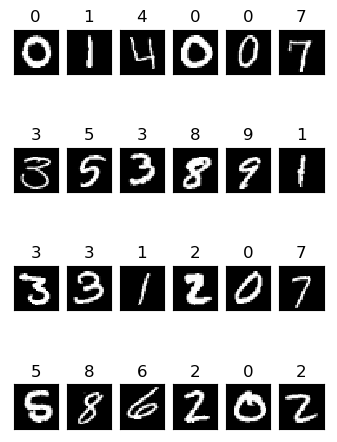

In [5]:
#visulaizing numbers in our dataset.
r = 4
c = 6
fig=plt.figure(figsize=(r, c),dpi=100)
for i in range(1, r*c+1):
    img = X[i].reshape(28,28)
    ax = fig.add_subplot(r, c, i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.title.set_text(Y[i])
    
    plt.imshow(img,cmap='gray')
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

trn_x,val_x,trn_y,val_y = train_test_split(X,Y,test_size=0.2)

In [7]:
#converting our data into a datloader object.

trn_x = torch.from_numpy(trn_x).type(torch.FloatTensor).view(-1,28,28)
trn_y = torch.from_numpy(trn_y).type(torch.LongTensor)

val_x = torch.from_numpy(val_x).type(torch.FloatTensor).view(-1,28,28)
val_y = torch.from_numpy(val_y).type(torch.LongTensor)

In [8]:
from torch.utils.data import TensorDataset,DataLoader

trn = TensorDataset(trn_x,trn_y)
trn = DataLoader(trn,batch_size=1000)

In [9]:
shape = trn_x[0].shape
shape

torch.Size([28, 28])

In [10]:
import torch.nn as nn
import torch.nn.functional as F

#   credits:
#   https://github.com/MorvanZhou/PyTorch-Tutorial/blob/master/tutorial-contents/402_RNN_classifier.py

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=28,
            hidden_size=64,         # rnn hidden unit
            num_layers=1,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.out = nn.Linear(64, 10)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out

rnn = RNN()

if cuda:
    rnn.cuda()
    
print(rnn)

RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)


In [11]:
#define our optimizer
from torch.optim import Adam

optimizer = Adam(rnn.parameters(), lr=1e-3)

In [12]:
def compute_val_loss(val_x,val_y,model):
    model.eval()
    if cuda:
        val_x,val_y = val_x.cuda(),val_y.cuda()
    output = model(val_x)
    loss = F.cross_entropy(output,val_y)
    return loss

In [13]:
EPOCHS = 10

trn_loss = []
val_loss = []


for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(trn):
        rnn.train()

        if cuda:
            data,target = data.cuda(),target.cuda()
            
        optimizer.zero_grad()

        y_pred = rnn(data)

        loss = F.cross_entropy(y_pred, target)
        trn_loss.append(loss.cpu().data.item())
        
        loss.backward()
        optimizer.step()
        
        loss = compute_val_loss(val_x,val_y,rnn)
        val_loss.append(loss.cpu().data.item())

    print("Epoch: {} | loss: {} | val_loss: {}".format(epoch+1,trn_loss[-1],val_loss[-1]))

Epoch: 1 | loss: 2.1386144161224365 | val_loss: 2.1246347427368164
Epoch: 2 | loss: 1.5547460317611694 | val_loss: 1.5242178440093994
Epoch: 3 | loss: 0.9099494218826294 | val_loss: 0.8649057745933533
Epoch: 4 | loss: 0.5838286280632019 | val_loss: 0.5460575819015503
Epoch: 5 | loss: 0.43799668550491333 | val_loss: 0.4225583076477051
Epoch: 6 | loss: 0.36748963594436646 | val_loss: 0.33707383275032043
Epoch: 7 | loss: 0.31840282678604126 | val_loss: 0.28870970010757446
Epoch: 8 | loss: 0.2909020483493805 | val_loss: 0.2564551532268524
Epoch: 9 | loss: 0.25978484749794006 | val_loss: 0.23021048307418823
Epoch: 10 | loss: 0.23379048705101013 | val_loss: 0.21909958124160767


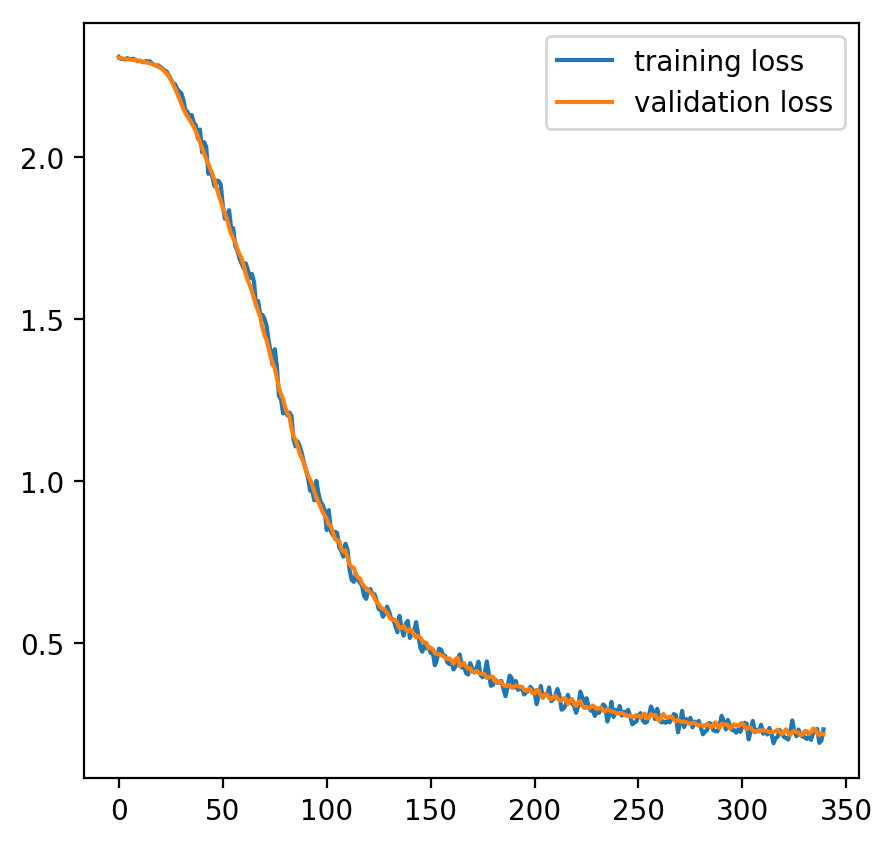

In [14]:
plt.figure(figsize=(5,5),dpi=200)
plt.plot(trn_loss,label='training loss')
plt.plot(val_loss,label='validation loss')
plt.legend(loc='upper right')

In [15]:
def predict_with_pytorch(model,val_x):
    model.eval()
    y_preds = []
    
    if cuda:
        val_x = val_x.cuda()
   
    out = model(val_x)
    _, predicted = torch.max(out.data,1)
    
    for p in predicted:
        y_preds.append(p.detach().cpu().numpy().item())
        
        
    return y_preds    

In [16]:
#predicting validation set and plotting a heatmap.

pred = predict_with_pytorch(rnn,val_x)

In [17]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(val_y.numpy(),pred)

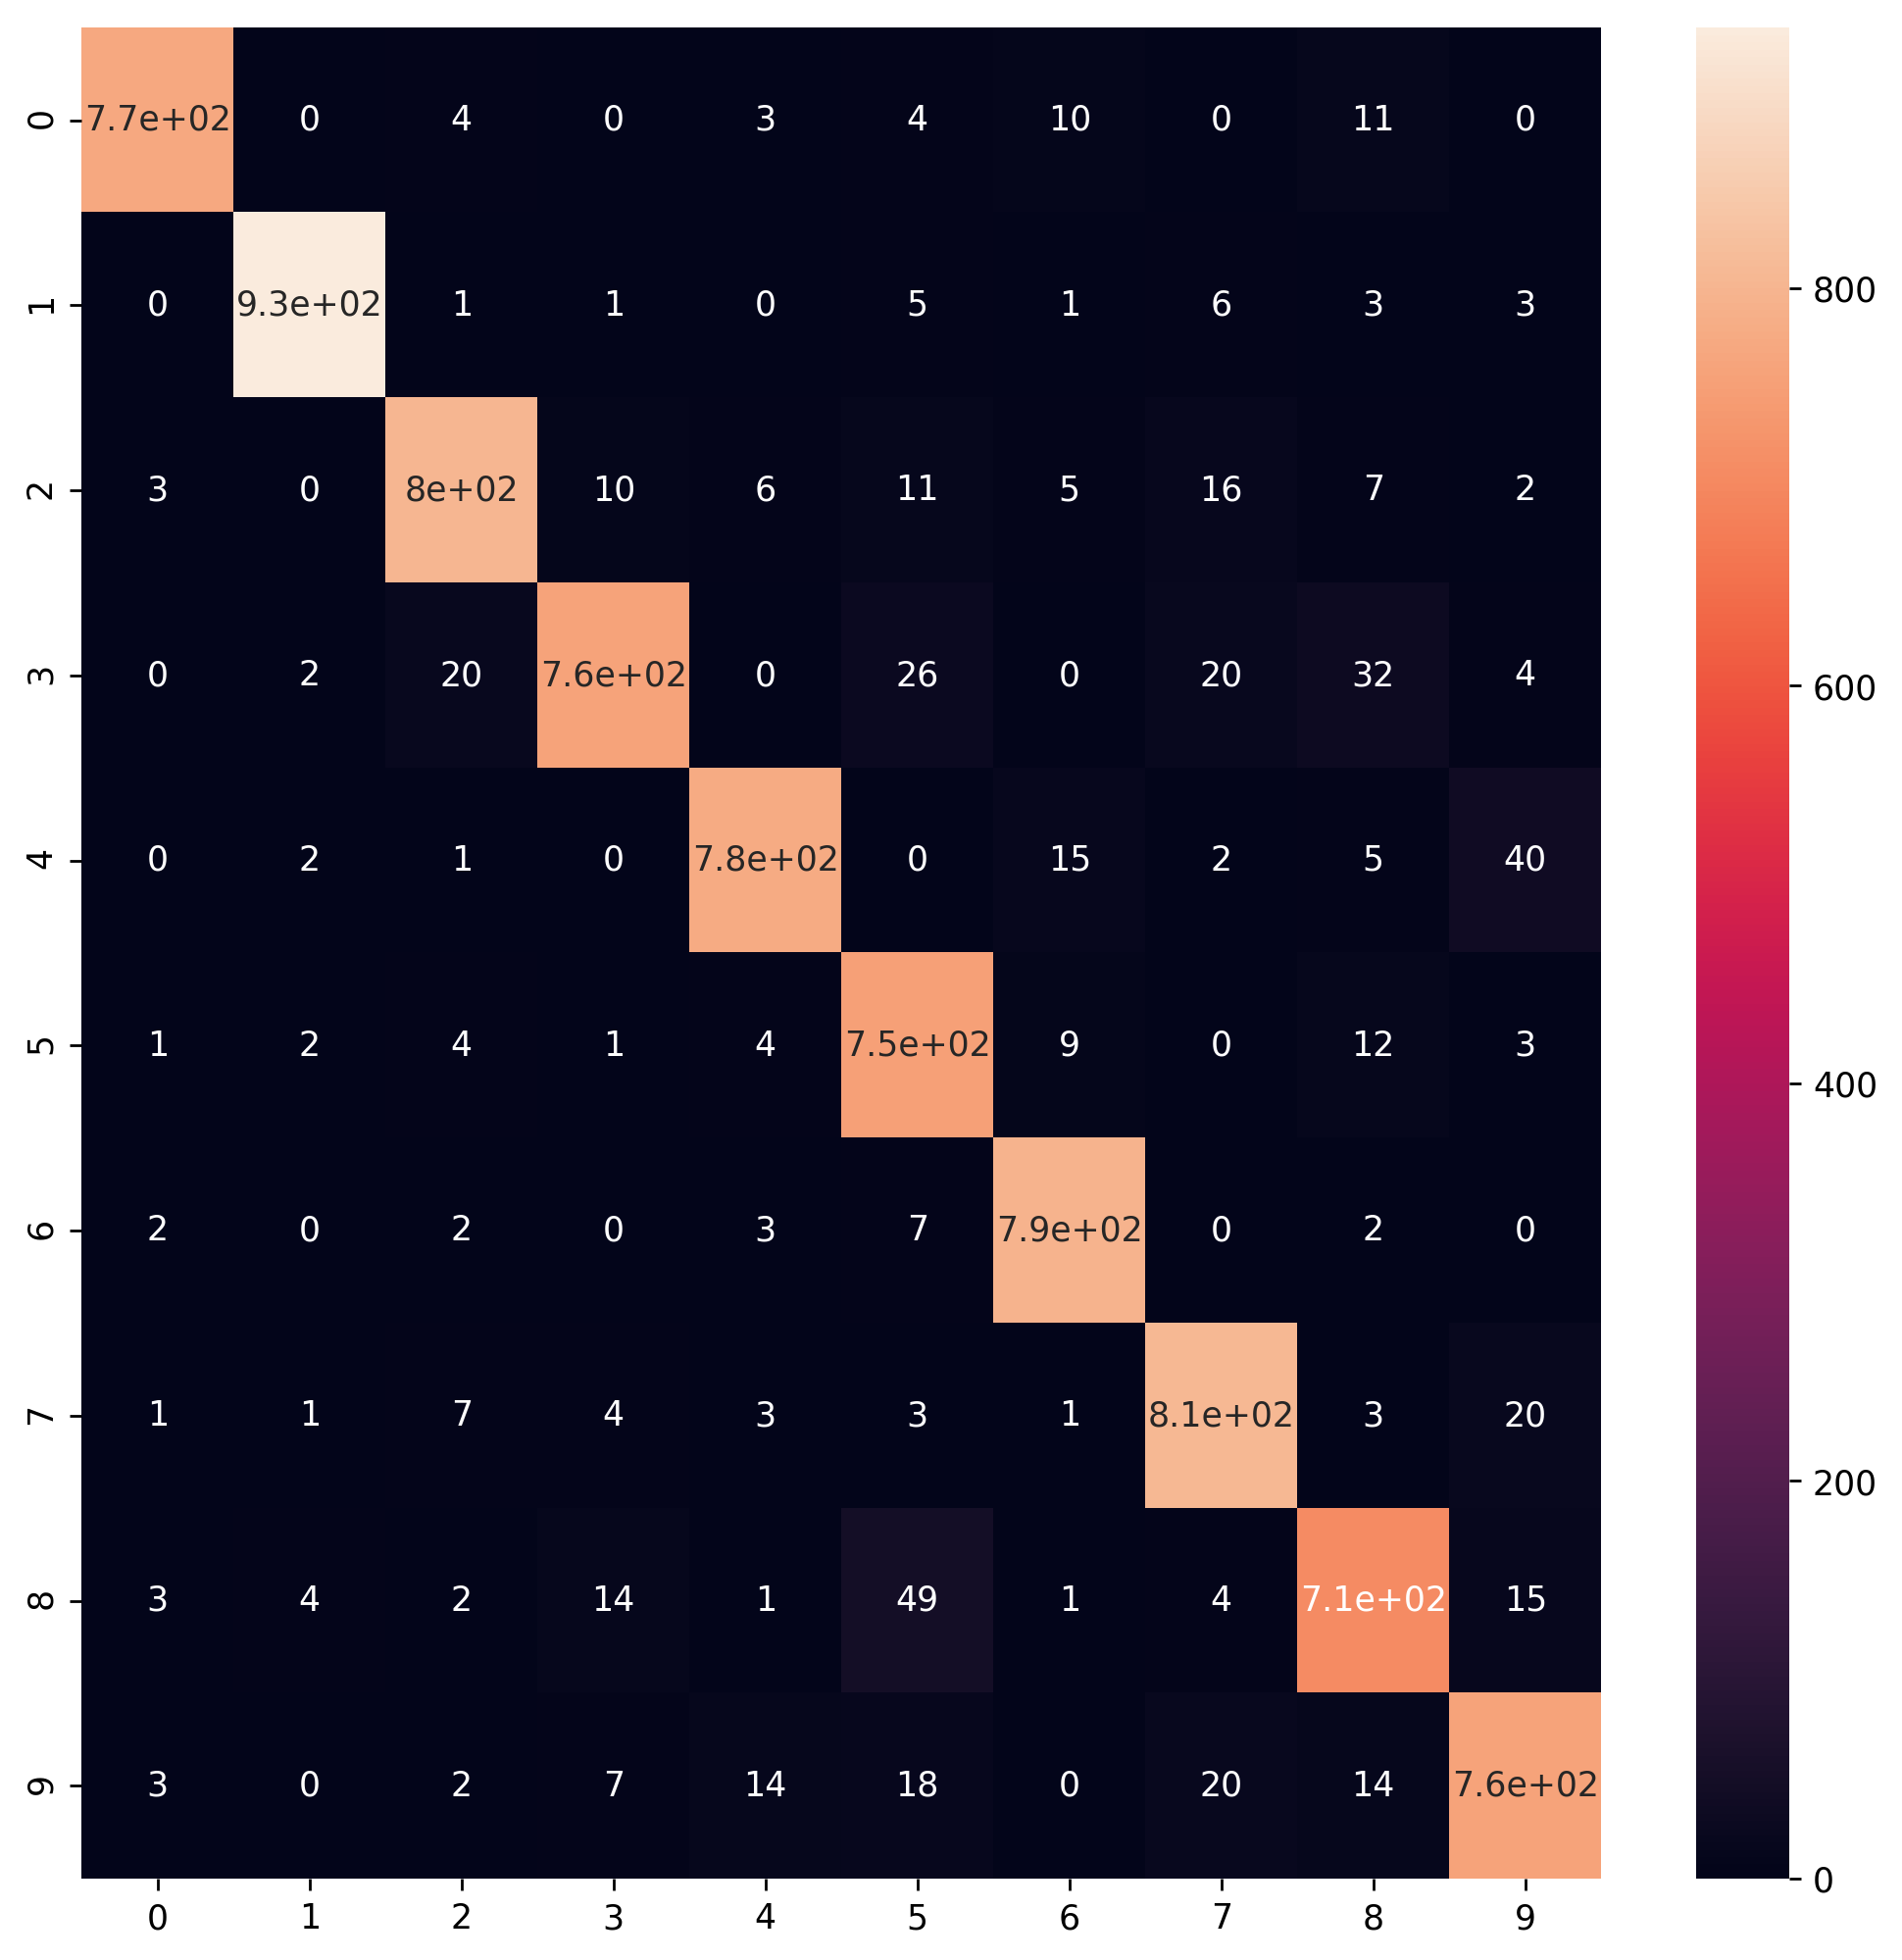

In [18]:
plt.figure(figsize = (10,10),dpi=250)
seaborn.heatmap(cm,annot=True)

In [19]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(val_y.numpy(),pred)

print("Accuracy:",acc*100,"%")

Accuracy: 93.4880952381 %
